# What sport are we talking?
## *Using NLP & Classification to differentiate between r/nfl and r/nba*
<br>

### Problem Statement:
How can we use NLP & Classification to differientiate between r/nfl and r/nba?

<br>

### Executive Summary:
Admittedly, I am a **huge** sports fan. I am a diehard Buffalo Bills fan, and I have always loved watching the NBA. But there are plenty of people out there that just aren't that interested in sports, that generally give blank stares when you ask them what they thought of NBA free-agency or who is going to win the SuperBowl. Well if those people want to get more involved, this notebook should help them at least determine if someone is talking about the NBA or the NFL and the relevant lingo for each. This notebook aims to achieve two main goals: scrape reddit's api for posts & comments and use natural language processing to build classification models that predict the subreddit for the text in a given post or comment. Not surprisingly, keywords like player name and team name are big indicators. Then there are position names and verbs that are unique to each sport that can help differentiate.

### Contents:
[1. Webscraping](#1.-Webscraping) <br>
[2. Merging the Datasets](#2.-Merging-the-Datasets) <br>
[3. Text Cleaning & Exploratory Data Analysis](#3.-Text-Cleaning-&-Exploratory-Data-Analysis) <br>
[4. Modeling](#4.-Modeling)<br>
[5. Conclusions](#5.-Conclusions)<br>
[6. Extra Models](#6.-Extra-Models)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk import regexp_tokenize, FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re
from PIL import Image

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

## 1. Webscraping

For this section, I have my code in markdown text rather than code blocks. If you'd like to run them, you just change the cell type and remove the backticks.

<div class="alert alert-block alert-info">I first ran a loop to get about 1000 comments from r/nba. After the loop, I picked out the relevant information I needed and created a list of row dictionaries which I turned into a dataframe.</div>

```
posts = []
after = None

for i in range(40):
    if after == None:
        params = {}
    else:
        params = {'after':after}
    url = 'https://www.reddit.com/r/nba.json'
    headers = {'User-agent':'cobkenney'}
    res = requests.get(url,params=params,headers=headers)
    if res.status_code == 200:
        json_dict = res.json()
        posts.extend(json_dict['data']['children'])
        after = json_dict['data']['after']
    else:
        print(res.status_code)
    time.sleep(1)
    
 # extract posts text from list of post dictionaries     
posts_text = []
for i in range(len(posts)):
    row_dict = {}
    row_dict['title'] = posts[i]['data'].get('title')
    row_dict['subtext'] = posts[i]['data'].get('selftext')
    row_dict['id'] = posts[i]['data'].get('name')
    row_dict['subreddit'] = posts[i]['data'].get('subreddit')
    row_dict['type'] = 'post'
    row_dict['author'] = posts[i]['data'].get('author')
    posts_text.append(row_dict)
    
posts_df = pd.DataFrame(posts_text).drop_duplicates()
posts_df.to_csv('../data/nba_posts.csv',index=False)
```

<div class="alert alert-block alert-info">Then I ran a loop to get comments on the first 100 posts from r/nba. After the loop, I picked out the relevant information I needed and created a list of row dictionaries which I turned into a dataframe. </div>

```
comments = []
after = None
    
for i in range(101):
    print(i)
    url = 'https://reddit.com/'+ posts[i]['data']['permalink'] + '.json'
    headers = {'User-agent':'cobkenney'}
    req = requests.get(url,headers=headers)

    if req.status_code == 200:
        comments_dict = req.json()
        comments.extend(comments_dict[1]['data']['children'])
    #after = comments_dict['data']['after']
    else:
        print(req.status_code)
    time.sleep(1)

 # extract comments text from list of comment dictionaries    
comments_text = []
for i in range(len(comments)):
    row_dict = {}
    row_dict['text'] = comments[i]['data'].get('body')
    row_dict['id'] = comments[i]['data'].get('id')
    row_dict['parent_id'] = comments[i]['data'].get('parent_id')
    row_dict['subreddit'] = comments[i]['data'].get('subreddit')
    row_dict['type'] = 'comment'
    row_dict['author'] = comments[i]['data'].get('author')
    comments_text.append(row_dict)
    
comments_df = pd.DataFrame(comments_text).drop_duplicates().dropna()
comments_df.to_csv('../data/nba_comments.csv',index=False)
```

<div class="alert alert-block alert-info">I then repeated these steps for r/nfl.</div>

```
nfl_posts = []
after = None

for i in range(40):
    print(i)
    if after == None:
        params = {}
    else:
        params = {'after':after}
    url = 'https://www.reddit.com/r/nfl.json'
    headers = {'User-agent':'cobkenney'}
    res = requests.get(url,params=params,headers=headers)
    if res.status_code == 200:
        json_dict = res.json()
        nfl_posts.extend(json_dict['data']['children'])
        after = json_dict['data']['after']
    else:
        print(res.status_code)
    time.sleep(1)

extract post text from list of post dictionaries  
nfl_posts_text = []
for i in range(len(nfl_posts)):
    row_dict = {}
    row_dict['title'] = nfl_posts[i]['data'].get('title')
    row_dict['subtext'] = nfl_posts[i]['data'].get('selftext')
    row_dict['id'] = nfl_posts[i]['data'].get('name')
    row_dict['subreddit'] = nfl_posts[i]['data'].get('subreddit')
    row_dict['type'] = 'post'
    row_dict['author'] = nfl_posts[i]['data'].get('author')
    nfl_posts_text.append(row_dict)

nfl_posts_df = pd.DataFrame(nfl_posts_text).drop_duplicates()
nfl_posts_df.to_csv('../data/nfl_posts.csv',index=False)
```

```
nfl_comments = []
after = None
    
for i in range(101):
    print(i)
    url = 'https://reddit.com/'+ nfl_posts[i]['data']['permalink'] + '.json'
    headers = {'User-agent':'cobkenney'}
    req = requests.get(url,headers=headers)

    if req.status_code == 200:
        comments_dict = req.json()
        nfl_comments.extend(comments_dict[1]['data']['children'])
    #after = comments_dict['data']['after']
    else:
        print(req.status_code)
    time.sleep(1)

extract comments text from list of comment dictionaries  
nfl_comments_text = []
for i in range(len(nfl_comments)):
    row_dict = {}
    row_dict['text'] = nfl_comments[i]['data'].get('body')
    row_dict['id'] = nfl_comments[i]['data'].get('id')
    row_dict['parent_id'] = nfl_comments[i]['data'].get('parent_id')
    row_dict['subreddit'] = nfl_comments[i]['data'].get('subreddit')
    row_dict['type'] = 'comment'
    row_dict['author'] = nfl_comments[i]['data'].get('author')
    nfl_comments_text.append(row_dict)

nfl_comments_df = pd.DataFrame(nfl_comments_text).drop_duplicates().dropna()
nfl_comments_df.to_csv('../data/nfl_comments.csv',index=False)
```

In [2]:
nba_posts = pd.read_csv('../data/nba_posts.csv')
nba_comments = pd.read_csv('../data/nba_comments.csv')

nfl_posts = pd.read_csv('../data/nfl_posts.csv')
nfl_comments = pd.read_csv('../data/nfl_comments.csv')

## 2. Merging the Datasets

In this section, I will merge the NBA posts and comments, the NFL posts and comments, and then the total NBA and NFL dataframes. I did have to do some cleaning since some posts did not have subtext.

In [3]:
# find nulls
nba_posts.isnull().sum()

author         0
id             0
subreddit      0
subtext      334
title          0
type           0
dtype: int64

In [4]:
# fill nulls
nba_posts['subtext'].fillna('',inplace=True)
# create column that combines title and body of post
nba_posts['text'] = nba_posts['title'] + ' ' + nba_posts['subtext']
# drop subtext
nba_posts.drop(columns=['subtext'],inplace=True)
# create blank parent_id column
nba_posts['parent_id'] = None
#reorder columns
nba_posts = nba_posts[['author','id','parent_id','subreddit','title','text','type']]

In [5]:
# add respective title of post to comment given parent_id

nba_posts_dict = pd.DataFrame.to_dict(nba_posts,orient='records')

titles = []
for i in range(102): # range is 102 since we only have comments on 101 posts
    row = {}
    row['title'] = nba_posts_dict[i].get('title')
    row['id'] = nba_posts_dict[i].get('id')
    titles.append(row)

titles_df = pd.DataFrame(titles)

# merge two nba dataframes
nba_comments = nba_comments.merge(titles_df, left_on='parent_id', right_on='id').drop(columns=['id_y'])
nba_comments.rename(columns={'id_x':'id'},inplace=True)

nba = pd.concat([nba_comments,nba_posts],sort=True)

In [6]:
nba.head()

,author,id,parent_id,subreddit,text,title,type
0,phatboi858,es8dwgl,t3_c6ffge,nba,Opening this post legit froze my phone for sev...,2019 NBA Free Agent Tracker,comment
1,WheedMBoise,es8e08t,t3_c6ffge,nba,Can't believe I found this on new. Thankfully ...,2019 NBA Free Agent Tracker,comment
2,AuburnSeer,esfrd09,t3_c6ffge,nba,Yeah KD is nice but have you tried JJ Reddick,2019 NBA Free Agent Tracker,comment
3,theislander849,esfwea8,t3_c6ffge,nba,Bets on how Kawhi announces:\n\n* Updating his...,2019 NBA Free Agent Tracker,comment
4,uhnahnuhmoose,es8s3cq,t3_c6ffge,nba,Isn’t Tyreke Evans banned or something?,2019 NBA Free Agent Tracker,comment


<div class="alert alert-block alert-info">Now I repeat these steps for r/nfl.</div>

In [7]:
nfl_posts.isnull().sum()

author         0
id             0
subreddit      0
subtext      597
title          0
type           0
dtype: int64

In [8]:
# fill nulls
nfl_posts['subtext'].fillna('',inplace=True)
# create column that combines title and body of post
nfl_posts['text'] = nfl_posts['title'] + ' ' + nfl_posts['subtext']
# drop subtext
nfl_posts.drop(columns=['subtext'],inplace=True)
# create blank parent_id column
nfl_posts['parent_id'] = None
#reorder columns
nfl_posts = nfl_posts[['author','id','parent_id','subreddit','title','text','type']]

In [9]:
nfl_comments['parent_id'].nunique()

100

In [10]:
# add respective title of post to comment given parent_id

nfl_posts_dict = pd.DataFrame.to_dict(nfl_posts,orient='records')

titles = []
for i in range(101): # range is 102 since we only have comments on 100 posts
    row = {}
    row['title'] = nfl_posts_dict[i].get('title')
    row['id'] = nfl_posts_dict[i].get('id')
    titles.append(row)

titles_df = pd.DataFrame(titles)

# merge two nba dataframes
nfl_comments = nfl_comments.merge(titles_df, left_on='parent_id', right_on='id').drop(columns=['id_y'])
nfl_comments.rename(columns={'id_x':'id'},inplace=True)

nfl = pd.concat([nfl_comments,nfl_posts],sort=True)

In [11]:
nfl.head()

,author,id,parent_id,subreddit,text,title,type
0,johndelvec3,et88vnm,t3_ca74h3,nfl,I don’t understand how people don’t like Stevi...,Sunday Brunch,comment
1,syedshazeb,et88trf,t3_ca74h3,nfl,Wolfhard has been a busy guy outside of Strang...,Sunday Brunch,comment
2,Arch_Stanton,et88frd,t3_ca74h3,nfl,Is this real?\n\nhttps://youtu.be/rq5pl-U57fQ,Sunday Brunch,comment
3,LilRipsta2,et882mx,t3_ca74h3,nfl,It finally cooled down for the first time in w...,Sunday Brunch,comment
4,KingEdTheMagnificent,et87xuu,t3_ca74h3,nfl,I had fun visiting my cousins this weekend. On...,Sunday Brunch,comment


In [12]:
# merge nfl & nba
df = pd.concat([nfl,nba])

## 3. Text Cleaning & Exploratory Data Analysis

In this section I wanted to remove hyperlinks from the text using regular expressions and visualize the most common words using wordclouds. These wordclouds are not meant to claim what words are the most important in determing which subreddit the post or comment belongs to. The modeling section will have more robust claims for those important words. However, I think it is interesting to visualize the most common in each.

In [13]:
df['subreddit'].value_counts(normalize=True)

nba    0.60141
nfl    0.39859
Name: subreddit, dtype: float64

In [14]:
df['type'].value_counts(normalize=True)

comment    0.76068
post       0.23932
Name: type, dtype: float64

In [15]:
df.shape

(7233, 7)

In [16]:
# remove hyperlinks and create new column
df['clean_text'] = df.text.map(lambda x: re.sub('http[s]?:\/\/[^\s]*', ' ', x))

<div class="alert alert-block alert-info">I also want to create some visuals for the most frequent words across the two subreddits and in each.</div>

(-0.5, 719.5, 719.5, -0.5)

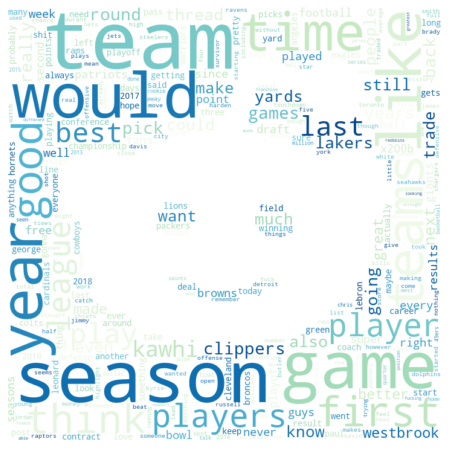

In [17]:
#https://stackoverflow.com/questions/49500259/how-to-find-most-frequently-used-words-used-on-data-using-python

def tokenize(text, pat='(?u)\\b\\w\\w+\\b', stop_words='english', min_len=2):
    if stop_words:
        stop = set(stopwords.words(stop_words))
    return [w
            for w in regexp_tokenize(text.casefold(), pat)
            if w not in stop and len(w) >= min_len]

words = tokenize(df['clean_text'].str.cat(sep=' '), min_len=4)

fdist = FreqDist(words)

mask = np.array(Image.open('../images/reddit.png'))

wc = WordCloud(random_state=43,width=800, height=400, max_words=300, colormap='GnBu',
               background_color='white',mask=mask).generate_from_frequencies(fdist)

plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

<div class="alert alert-block alert-info">Not surprisingly, words like season, game, and team are very common in both subreddits because these are sports subreddits.</div>

(-0.5, 899.5, 619.5, -0.5)

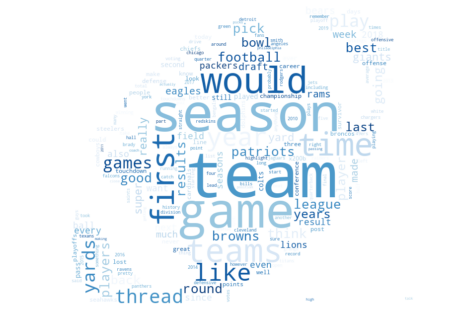

In [18]:
#https://stackoverflow.com/questions/49500259/how-to-find-most-frequently-used-words-used-on-data-using-python

def tokenize(text, pat='(?u)\\b\\w\\w+\\b', stop_words='english', min_len=2):
    if stop_words:
        stop = set(stopwords.words(stop_words))
    return [w
            for w in regexp_tokenize(text.casefold(), pat)
            if w not in stop and len(w) >= min_len]

words = tokenize(df[df['subreddit']=='nfl']['clean_text'].str.cat(sep=' '), min_len=4)

fdist = FreqDist(words)

mask = np.array(Image.open('../images/nfl.jpg'))

wc = WordCloud(random_state=43,width=800, height=400, max_words=200, colormap='Blues',
               background_color='white',mask=mask).generate_from_frequencies(fdist)

plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

<div class="alert alert-block alert-info">Team, season, and game are still very common, but team names are bigger like Patriots and Browns.</div>

(-0.5, 543.5, 517.5, -0.5)

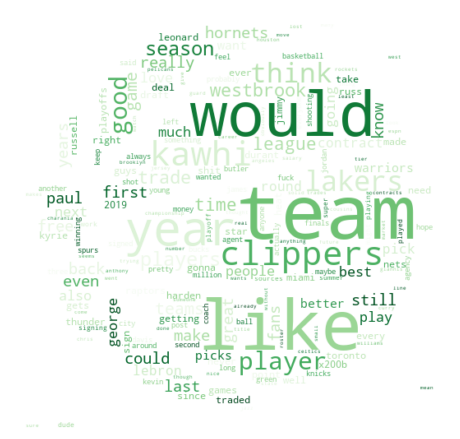

In [19]:
#https://stackoverflow.com/questions/49500259/how-to-find-most-frequently-used-words-used-on-data-using-python

def tokenize(text, pat='(?u)\\b\\w\\w+\\b', stop_words='english', min_len=2):
    if stop_words:
        stop = set(stopwords.words(stop_words))
    return [w
            for w in regexp_tokenize(text.casefold(), pat)
            if w not in stop and len(w) >= min_len]

words = tokenize(df[df['subreddit']=='nba']['clean_text'].str.cat(sep=' '), min_len=4)

fdist = FreqDist(words)

mask = np.array(Image.open('../images/nba.jpg'))

wc = WordCloud(random_state=43,width=800, height=400, max_words=200, colormap='Greens',
               background_color='white',mask=mask).generate_from_frequencies(fdist)

plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

<div class="alert alert-block alert-info">Team was still very common in the NBA, but words like Kawhi, Clippers, and even like were also very common.</div>

In [20]:
df.to_csv('../data/merged_df.csv',index=False)

## 4. Modeling

In this section, I want to use my text column or clean_text column (without hyperlinks) to predict which subreddit that the post or comment came from. <br>
<br>
I am going to do a few different iterations of the models:<br>
<br>
    [4.1 Using both Comments & Posts](#4.1-Using-both-Comments-&-Posts)<br>
    [4.2 Using only Posts](#4.2-Using-only-Posts)<br>
    [4.3 Using only Posts without 'nfl' and 'nba' as features](#4.3-Using-only-Posts-without-'nfl'-and-'nba'-as-features)
<br>

#### Baseline Accuracy:
60.1% since the majority class accounts for 60.1% of the data.

In [21]:
df['subreddit'].value_counts(normalize=True)

nba    0.60141
nfl    0.39859
Name: subreddit, dtype: float64

### 4.1 Using both Comments & Posts

In this subsection, I will focus on using both comments & posts with "uncleaned" text (with hyperlinks) and clean_text. I am not going to repeat the code for clean_text, but I will show the clean_text model scores at the bottom. The only thing you'd need to change is X = df [ 'text' ] to X = df [ 'clean_text' ]. The optimal parameters for the vectorizer is the same across the two columns, and best models were the same. Interestingly, the scores were the same. So cleaning the text did not seem to make a difference. <br>
<br>
First, I am going to optimize parameters for the vectorizer based on a Logistic Regression. After I have those optimal parameters for my vectorizer, I am going to vectorize my data and find the best models besides Logistic Regression. These optimal vectorizers parameters could be different based on a different model, but we have to vectorize the find the best models.

In [22]:
X = df['text']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [23]:
pipe = Pipeline([('cvec', CountVectorizer()),
                 ('lr', LogisticRegression())])

params = {
    'cvec__max_features': [1000, 2000],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words':[None, 'english'],
}

gs = GridSearchCV(pipe, param_grid=params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.8523230088495575


{'cvec__max_features': 2000,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english'}

In [24]:
cvec = CountVectorizer(
                       stop_words = 'english',
                       ngram_range = (1,1),
                       max_features = 2000 
                        )
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [25]:
models_to_consider ={
    LogisticRegression:{'C':[1,10]},
    MultinomialNB:{},
    SVC: {'random_state':[42],'gamma':['scale'], 'kernel':['linear', 'rbf'],'C':[1,10]},
    RandomForestClassifier: {'random_state':[42],'min_samples_split': [5, 10]},
    BaggingClassifier: {'n_estimators':[10,100],'random_state':[42]},     
    GradientBoostingClassifier: {'n_estimators':[10,100],'random_state':[42],'learning_rate':[1,0.8]}     
}

In [26]:
def best_model(X_train_vect,y_train,models_to_consider):
    models = {}
    for model_type,params in models_to_consider.items():
        model = model_type()
        gs = GridSearchCV(model,param_grid=params,cv=3)
        gs.fit(X_train_vect,y_train)
        models[gs.best_score_] = model_type, gs.best_params_
    return models

In [27]:
# best_model(X_train_cvec,y_train,models_to_consider)

This is the output of the above function when using X = df [ 'text' ]:

**0.8561946902654868**: (sklearn.linear_model.logistic.**LogisticRegression**,{'C': 1}),<br>
 **0.8582227138643068**: (sklearn.naive_bayes.**MultinomialNB**, {}),<br>
 **0.8381268436578171**: (sklearn.svm.classes.**SVC**,{'C': 1, 'gamma': 'scale', 'kernel': 'linear', 'random_state': 42}), <br>
 **0.8414454277286135**: (sklearn.ensemble.forest.**RandomForestClassifier**,{'min_samples_split': 10, 'random_state': 42}),<br>
 **0.8231932153392331**: (sklearn.ensemble.bagging.**BaggingClassifier**,{'n_estimators': 10, 'random_state': 42}),<br>
 **0.8471607669616519**: (sklearn.ensemble.gradient_boosting.**GradientBoostingClassifier**,{'learning_rate':  0.8,'n_estimators': 100, 'random_state': 42})

<div class="alert alert-block alert-info">This function takes a very long time to run since we are gridsearching through so many parameters in so many different models. Logistic Regression with C = 1 and MultiNomial Bayes were the best after running this function. I am also going to use a Random Forest to get feature importances below.</div>

In [28]:
lr = LogisticRegression(C=1,random_state=42)
lr.fit(X_train_cvec,y_train)
print(f"Logistic Regression Train Score {lr.score(X_train_cvec,y_train)}")
print(f"Logistic Regression Test Score {lr.score(X_test_cvec,y_test)}")
mb = MultinomialNB()
mb.fit(X_train_cvec.toarray(),y_train)
print(f"MultiNomial Bayes Train Score {mb.score(X_train_cvec.toarray(),y_train)}")
print(f"MultiNomial Bayes Train Score {mb.score(X_test_cvec.toarray(),y_test)}")
rf = RandomForestClassifier(random_state=42,min_samples_split=10)
rf.fit(X_train_cvec.toarray(),y_train)
print(f"Random Forest Train Score {rf.score(X_train_cvec.toarray(),y_train)}")
print(f"Random Forest Train Score {rf.score(X_test_cvec.toarray(),y_test)}")

Logistic Regression Train Score 0.9319690265486725
Logistic Regression Test Score 0.8524046434494196
MultiNomial Bayes Train Score 0.8753687315634219
MultiNomial Bayes Train Score 0.8590381426202321
Random Forest Train Score 0.9502212389380531
Random Forest Train Score 0.845771144278607


|**Model**|**Clean Text Test Score**|**Regular Text Test Score**|
|---|---|---|
|*Logistic Regression*|0.8491|0.8491
|*MultiNomial Bayes*|0.8563|0.8563
|*Random Forest*|0.8353|0.8353

<div class="alert alert-block alert-info">Overall, the models are all somewhat overfit (Random Forests being the most which makes sense), but they are pretty good at predicting the respective subreddit for comments and posts (around 84% accuracy), but I have a feeling they will be better at predicting just posts. In the next section, I am going to run the same models using only rows where type = post.</div>

### 4.2 Using only Posts

In this subsection, I will focus on using only posts with "uncleaned" text (with hyperlinks) and clean_text. I am not going to repeat the code for clean_text, but I will show the clean_text model scores at the bottom. The only thing you'd need to change is X = df [ 'text' ] to X = df [ 'clean_text' ]. The optimal parameters for the vectorizer was ngrams = (1,1) for text and ngrams = (1,2) for clean_text.

In [29]:
X = df[df['type']=='post']['text']
y = df[df['type']=='post']['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=42)

In [30]:
pipe = Pipeline([('tvec', CountVectorizer()),
                 ('lr', LogisticRegression())])

params = {
    'tvec__max_features': [1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words':[None, 'english'],
}

gs = GridSearchCV(pipe, param_grid=params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.9314329738058552


{'tvec__max_features': 2000,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [31]:
tvec = TfidfVectorizer(
                       stop_words = 'english',
                       ngram_range = (1,1),
                       max_features = 2000  
                        )

In [32]:
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

In [33]:
#best_model(X_train_tvec,y_train,models_to_consider)

**0.9460708782742681**: (sklearn.linear_model.logistic.**LogisticRegression**,{'C': 10}),<br>
**0.9368258859784283**: (sklearn.naive_bayes.**MultinomialNB**, {}), <br>
**0.9414483821263482**: (sklearn.svm.classes.**SVC**,{'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'random_state': 42}),<br>
**0.9021571648690293**: (sklearn.ensemble.forest.**RandomForestClassifier**,{'min_samples_split': 5, 'random_state': 42}),<br>
**0.8628659476117103**: (sklearn.ensemble.bagging.**BaggingClassifier**,{'n_estimators': 100, 'random_state': 42}),<br>
**0.8798151001540832**: (sklearn.ensemble.gradient_boosting.**GradientBoostingClassifier**,{'learning_rate': 1, 'n_estimators': 100, 'random_state': 42})

<div class="alert alert-block alert-info">SVM actually outperformed MultiNomial Bayes in this case for both text and clean_text. For consistency, I am going to still use Logistic Regression, MultiNomial Bayes, and RandomForest so we can compare. Interestingly, the best C was 10 in this case. This could be due to using the TF IDF as the vectorizer versus using countvectorizer.</div>

In [34]:
lr = LogisticRegression(C=10,random_state=42)
lr.fit(X_train_tvec,y_train)
print(f"Logistic Regression Test Score {lr.score(X_test_tvec,y_test)}")
mb = MultinomialNB()
mb.fit(X_train_tvec.toarray(),y_train)
print(f"MultiNomial Bayes Test Score {mb.score(X_test_tvec.toarray(),y_test)}")
rf = RandomForestClassifier(random_state=42,min_samples_split=5)
rf.fit(X_train_tvec.toarray(),y_train)
print(f"Random Forest Test Score {rf.score(X_test_tvec.toarray(),y_test)}")

Logistic Regression Test Score 0.9561200923787528
MultiNomial Bayes Test Score 0.9561200923787528
Random Forest Test Score 0.9145496535796767


|**Model**|**Clean Text Test Score**|**Regular Text Test Score**|
|---|---|---|
|*Logistic Regression*|0.9561|0.9561
|*MultiNomial Bayes*|0.9446|0.9561
|*Random Forest*|0.9145|0.9145

<div class="alert alert-block alert-info">Using clean_text(without hyperlinks) actually slightly decreases the score for MultiNomial Bayes. Otherwise, using clean_text versus text seems to make little difference.</div>

##### Comparing Predicting Posts versus Predicting Posts & Comments

<br>
Using X = df [ 'text' ]
<br>

|**Model**|**Post & Comments Test Score**|**Posts Test Score**|
|---|---|---|
|*Logistic Regression*|0.8491|0.9561
|*MultiNomial Bayes*|0.8563|0.9561
|*Random Forest*|0.8353|0.9145

<div class="alert alert-block alert-info">The models are much better at predicting the subreddit of a post than of a post or comment. This makes sense intuitively since comments could have only a few words. Now let's look at a confusion matrix and and some visualizations to see the most differentiating words.</div>

In [35]:
preds = lr.predict(X_test_tvec)
confusion_matrix(y_test,preds)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
spec = tn/(tn+fp)
sens = tp/(tp+fn)
accuracy = (tp+tn)/(tn+tp+fp+fn)
misclassification = 1 - accuracy

print(f"Accuracy of our model: {round(accuracy*100,2)}%")
print(f"Misclassification rate of our model: {round(misclassification*100,2)}%")
print(f"Specificity of our model: {round(spec*100,2)}%")
print(f"Sensitivity of our model: {round(sens*100,2)}%")

cm = pd.DataFrame(confusion_matrix(y_test, preds),
                   index=['actual negative','actual positive'], 
                   columns=['predicted negative','predicted positive'])
cm

Accuracy of our model: 95.61%
Misclassification rate of our model: 4.39%
Specificity of our model: 95.12%
Sensitivity of our model: 96.05%


,predicted negative,predicted positive
actual negative,195,10
actual positive,9,219


<div class="alert alert-block alert-info">The model overall has fairly high accuracy, specificity, and sensitivity. Now let's check out some visualizations using the Random Forest model and the Logistic Regression model.</div>

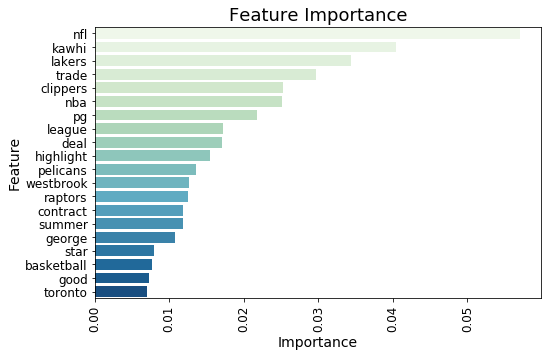

In [36]:
feature_importance = rf.feature_importances_
importance = pd.DataFrame(zip(tvec.get_feature_names(),feature_importance))
importance.rename(columns={0:'Feature',1:'Importance'},inplace=True)
top_20 = importance.sort_values('Importance',ascending=False).head(20)

plt.figure(figsize=(8,5))
sns.barplot(x=top_20['Importance'],y=top_20['Feature'],palette='GnBu')
plt.yticks(fontsize=12)
plt.ylabel('Feature',fontsize=14)
plt.xlabel('Importance',fontsize=14)
plt.xticks(fontsize=12,rotation=90)
plt.title('Feature Importance',fontsize=18);

<div class="alert alert-block alert-info">NFL was the most important feature in the Random Forest. Other words like Kawhi, Lakers, and trade were then important relative to nfl.</div>

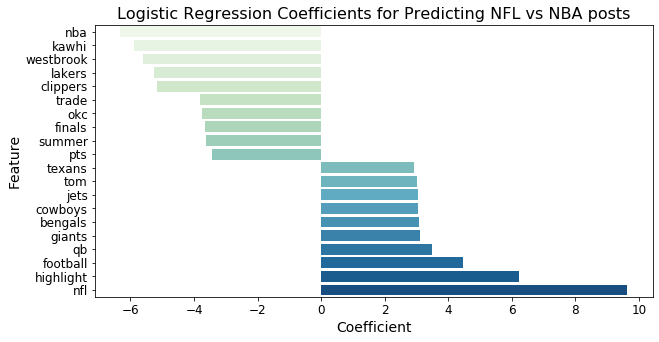

In [37]:
coefs = pd.DataFrame(zip(tvec.get_feature_names(),lr.coef_[0]))
coefs.rename(columns={0:'Feature',1:'Coefficient'},inplace=True)
coefs['e^(coefficient)'] = np.exp(coefs['Coefficient'])
top_nba = coefs.sort_values('Coefficient').head(10)
top_nfl = coefs.sort_values('Coefficient').tail(10)
top = pd.concat([top_nba,top_nfl])

plt.figure(figsize=(10,5))
sns.barplot(x=top['Coefficient'],y=top['Feature'],palette='GnBu')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Feature',fontsize=14)
plt.xlabel('Coefficient',fontsize=14)
plt.title('Logistic Regression Coefficients for Predicting NFL vs NBA posts',fontsize=16);

<div class="alert alert-block alert-info">Above are the 10 largest and 10 smallest(most negative) coefficients in the Logistic Regression model that indicates what words have a big impact on predicting NFL (positive case) vs NBA (negative case). Not surprisingly, NBA and NFL are the most divergent coefficients. Highlight surprised me as the second biggest coefficient for NFL.</div>

### 4.3 Using only Posts without 'nfl' and 'nba' as features

The words NBA and NFL kind of seem like cheating. Intuitively, if someone mentions the word NFL, they are probably talking about the NFL. In this subsection, I am going to use the models in 4.3 and just use X = df [ 'text' ] to predict subreddit since clean_text seemed to make no difference, but include nba and nfl as stopwords to see how much my models were depending on those two words.

In [38]:
stop = stopwords.words('english')
stop.extend(['nfl','nba'])

In [39]:
tvec = TfidfVectorizer(
                       stop_words = set(stop),
                       ngram_range = (1,1),
                       max_features = 2000  
                        )

In [40]:
X = df[df['type']=='post']['text']
y = df[df['type']=='post']['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [41]:
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

In [42]:
lr = LogisticRegression(C=10,random_state=42)
lr.fit(X_train_tvec,y_train)
print(f"Test Score Logistic Regression {lr.score(X_test_tvec,y_test)}")
mb = MultinomialNB()
mb.fit(X_train_tvec.toarray(),y_train)
print(f"MultiNomial Bayes Test Score {mb.score(X_test_tvec.toarray(),y_test)}")
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tvec.toarray(),y_train)
print(f"Random Forest Test Score {rf.score(X_test_tvec.toarray(),y_test)}")

Test Score Logistic Regression 0.930715935334873
MultiNomial Bayes Test Score 0.9260969976905312
Random Forest Test Score 0.8775981524249422


|**Model**|**Posts Test Score**|**Posts without nba and nfl**|
|---|---|---|
|*Logistic Regression*|0.9561|0.9307
|*MultiNomial Bayes*|0.9561|0.9261
|*Random Forest*|0.9145|0.8776

<div class="alert alert-block alert-info">The models were definitely better at predicting when nba or nfl was mentioned, but Random Forests seemed to depend on those words the most. Logistic Regression did the best of the 3 models when those words were taken out.</div>

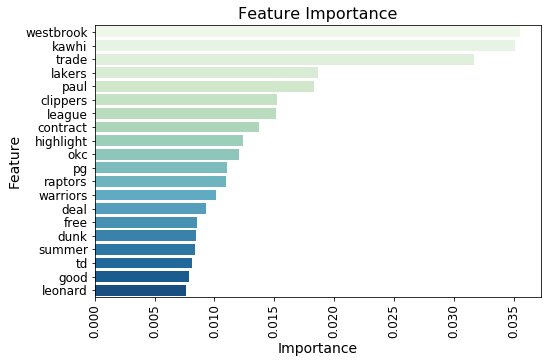

In [43]:
feature_importance = rf.feature_importances_
importance = pd.DataFrame(zip(tvec.get_feature_names(),feature_importance))
importance.rename(columns={0:'Feature',1:'Importance'},inplace=True)
top_20 = importance.sort_values('Importance',ascending=False).head(20)

plt.figure(figsize=(8,5))
sns.barplot(x=top_20['Importance'],y=top_20['Feature'],palette='GnBu')
plt.yticks(fontsize=12)
plt.ylabel('Feature',fontsize=14)
plt.xlabel('Importance',fontsize=14)
plt.xticks(fontsize=12,rotation=90)
plt.title('Feature Importance',fontsize=16);

<div class="alert alert-block alert-info">The most important features in the Random Forest model seemed to be mostly NBA related terms.</div>

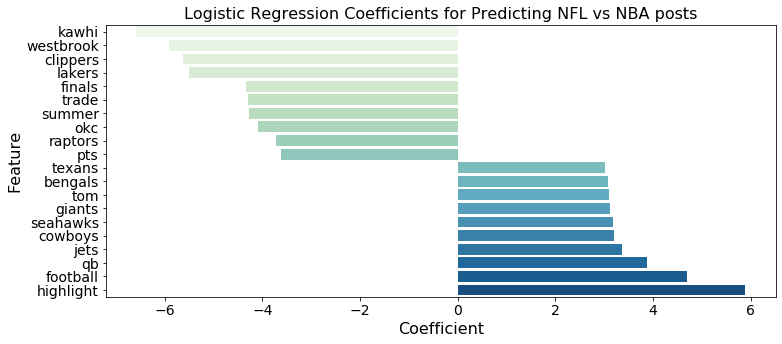

In [44]:
coefs = pd.DataFrame(zip(tvec.get_feature_names(),lr.coef_[0]))
coefs.rename(columns={0:'Feature',1:'Coefficient'},inplace=True)
coefs['e^(coefficient)'] = np.exp(coefs['Coefficient'])
top_nba = coefs.sort_values('Coefficient').head(10)
top_nfl = coefs.sort_values('Coefficient').tail(10)
top = pd.concat([top_nba,top_nfl])

plt.figure(figsize=(12,5))
sns.barplot(x=top['Coefficient'],y=top['Feature'],palette='GnBu')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Feature',fontsize=16)
plt.xlabel('Coefficient',fontsize=16)
plt.title('Logistic Regression Coefficients for Predicting NFL vs NBA posts',fontsize=16);

<div class="alert alert-block alert-info">The coefficient ranking looks very similar to the coefficients for the model in 4.2.</div>

## 5. Conclusions

When predicting whether or not a post or comment came from r/nfl or r/nba, posts were easier to classify than posts & comments. Removing words like nba and nfl reduced accuracy in my models, but not hugely. My logistic regression model was 95.61% accurate when I kept nba and nfl as words, but it was still 93.07% accurate when I took those words out. Player names and team names were strong features in predicting the subreddit. For example, Kawhi & Clippers were large negative coefficients in my logistic regression model. Westbrook and Kawhi were my most important features in my random forest model. After player names and team names, positions were another important differentiator. Qb was one of the largest positive coefficients for my logistic regression. Overall, the lingo for each sport is fairly distinguishable. <br>

For the future, I want to expand my dataset since these terms are really relevant for June-July 2019, but may not be relevant in a year or in 10 years. The team names will most likely be the same, but the players will be different. For the future, I want to expand my dataset since these terms are really relevant for June-July 2019, but may not be relevant in a year or in 10 years. The team names will most likely be the same, but the players will be different. I would also like extend the model into a multi-class model with more sports subreddits to help differentiate between other sports.

## 6. Extra Models

In this section, I ran a few extra models that used different predictors just for fun.

[6.1 Classify Fake Sentences](#6.1-Classify-Fake-Sentences)<br>
[6.2 Using Username to Predict Subreddit](#6.2-Using-Username-to-Predict-Subreddit)<br>
[6.3 Using Text to Predict Type of Text](#6.3-Using-Text-to-Predict-Type-of-Text)<br>
[6.4 Using Length of Post to Predict Subreddit](#6.4-Using-Length-of-Post-to-Predict-Subreddit)

### 6.1 Classify Fake Sentences 

In [45]:
sentences = ['Tom dunked on me but i still scored a touchdown',
             'I hate the nba but i love the nfl',
             'Check out this sick score',
             'hi there',
             'kawhi to the lakers',
             'playoffs are coming up',
             'nfl highlight football qb cowboys yards nba kawhi westbrook lakers clippers trade'
           ]
testing = pd.DataFrame(sentences,columns=['text'])

In [46]:
testing_tvec = tvec.transform(testing['text'])

In [47]:
lr.predict(testing_tvec)

array(['nfl', 'nba', 'nfl', 'nfl', 'nba', 'nba', 'nba'], dtype=object)

### 6.2 Using Username to Predict Subreddit

In [48]:
X = df[df['type']=='post']['author']
y = df[df['type']=='post']['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [49]:
tvec = TfidfVectorizer(
                       stop_words = 'english',
                       ngram_range = (1,1),
                       max_features = 2000  
                        )

In [50]:
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

In [51]:
lr = LogisticRegression(C=10,random_state=42)
lr.fit(X_train_tvec,y_train)
print(f"Train Score Logistic Regression {lr.score(X_train_tvec,y_train)}")
print(f"Test Score Logistic Regression {lr.score(X_test_tvec,y_test)}")

Train Score Logistic Regression 0.9961479198767335
Test Score Logistic Regression 0.7644341801385681


<div class="alert alert-block alert-info">Username proved to be much less accurate, but I wonder if using more data would be helpful. I only have about 1000 posts per subreddit, so I wonder if there would be a more distinguishable pattern if I had more posts.</div>

### 6.3 Using Text to Predict Type of Text

In this subsection, I used text to predict type for posts & comments in the NBA subreddit. The baseine accuracy is 76% since the majority class represents 76% of the data.

In [52]:
df['type'].value_counts(normalize=True)

comment    0.76068
post       0.23932
Name: type, dtype: float64

In [53]:
X = df[df['subreddit']=='nba']['text']
y = df[df['subreddit']=='nba']['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [54]:
tvec = TfidfVectorizer(
                       stop_words = 'english',
                       ngram_range = (1,1),
                       max_features = 2000  
                        )

In [55]:
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

In [56]:
lr = LogisticRegression(C=10,random_state=42)
lr.fit(X_train_tvec,y_train)
print(f"Test Score Logistic Regression {lr.score(X_test_tvec,y_test)}")
mb = MultinomialNB()
mb.fit(X_train_tvec.toarray(),y_train)
print(f"MultiNomial Bayes Test Score {mb.score(X_test_tvec.toarray(),y_test)}")
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tvec.toarray(),y_train)
print(f"Random Forest Test Score {rf.score(X_test_tvec.toarray(),y_test)}")

Test Score Logistic Regression 0.8869485294117647
MultiNomial Bayes Test Score 0.8612132352941176
Random Forest Test Score 0.8556985294117647


<div class="alert alert-block alert-info">Text was better at predicting type than username was at predicting subreddit (88.69% vs 76.44% for Logistic Regression).</div>

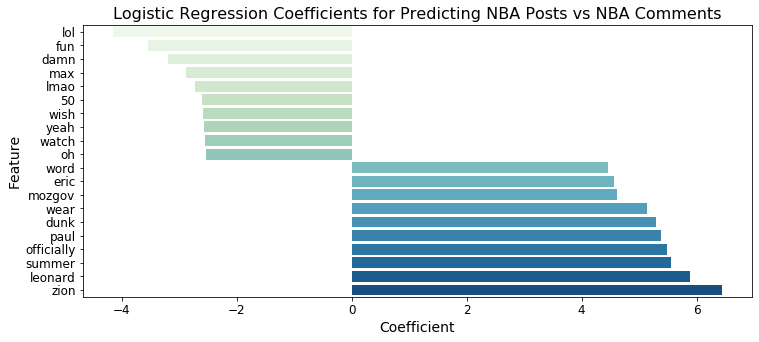

In [57]:
coefs = pd.DataFrame(zip(tvec.get_feature_names(),lr.coef_[0]))
coefs.rename(columns={0:'Feature',1:'Coefficient'},inplace=True)
coefs['e^(coefficient)'] = np.exp(coefs['Coefficient'])
top_nba = coefs.sort_values('Coefficient').head(10)
top_nfl = coefs.sort_values('Coefficient').tail(10)
top = pd.concat([top_nba,top_nfl])
plt.figure(figsize=(12,5))
sns.barplot(x=top['Coefficient'],y=top['Feature'],palette='GnBu')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Feature',fontsize=14)
plt.xlabel('Coefficient',fontsize=14)
plt.title('Logistic Regression Coefficients for Predicting NBA Posts vs NBA Comments',fontsize=16);

<div class="alert alert-block alert-info">Interestingly, words like lol and lmao were some of the most negative coefficients in predicting a post versus a comment.</div>

### 6.4 Using Length of Post to Predict Subreddit

In [58]:
word_count = []
for i in range(len(df['text'])):
    word_count.append(len(df.iloc[i]['text']))

In [59]:
df['word_count'] = word_count

In [60]:
X = df[df['type']=='post'][['word_count']]
y = df[df['type']=='post']['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [61]:
lr = LogisticRegression(C=10,random_state=42)
lr.fit(X_train,y_train)
print(f"Train Score Logistic Regression {lr.score(X_train,y_train)}")
print(f"Test Score Logistic Regression {lr.score(X_test,y_test)}")

Train Score Logistic Regression 0.5269645608628659
Test Score Logistic Regression 0.5265588914549654


<div class="alert alert-block alert-info">This is actually worse than the baseline accuracy of about 60%.</div>